In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [2]:
#LOAD THE DATASET
path = "D:/DataScience/Project/UTKface27k/"
files = os.listdir(path)
size = len(files)
print('Total samples:', size)
print(files[0])

Total samples: 23705
100_0_0_20170112213500903.jpg.chip.jpg


In [3]:
images = []
ages = []
genders = []
for filename in tqdm(os.listdir(path)):
    image_path = os.path.join(path, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    images.append(image_path)
    ages.append(age)
    genders.append(gender)

  0%|          | 0/23705 [00:00<?, ?it/s]

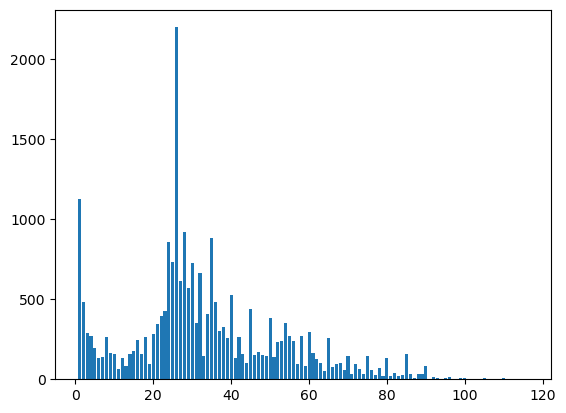

Max value: 116


In [4]:
x_ages = list(set(ages))
y_ages = [ages.count(i) for i in x_ages]
plt.bar(x_ages,y_ages)
plt.show()
print("Max value:", max(ages))

In [5]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = images, ages, genders
df.head()

,image,age,gender
0,D:/DataScience/Project/UTKface27k/100_0_0_2017...,100,0
1,D:/DataScience/Project/UTKface27k/100_0_0_2017...,100,0
2,D:/DataScience/Project/UTKface27k/100_1_0_2017...,100,1
3,D:/DataScience/Project/UTKface27k/100_1_0_2017...,100,1
4,D:/DataScience/Project/UTKface27k/100_1_0_2017...,100,1


In [6]:
gender_dict = {0:'Male', 1:'Female'}

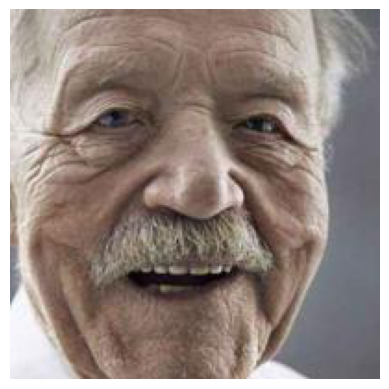

In [7]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img)

<Axes: xlabel='age', ylabel='Density'>

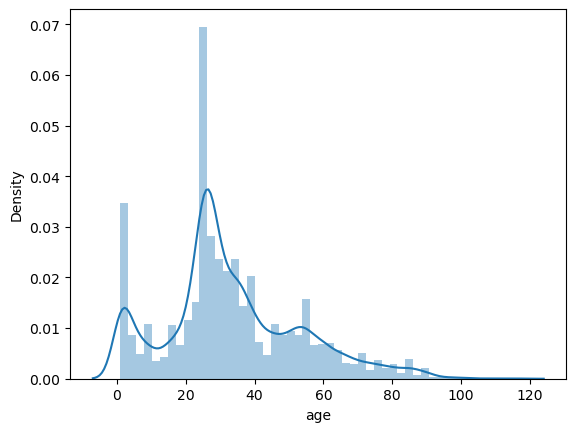

In [8]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

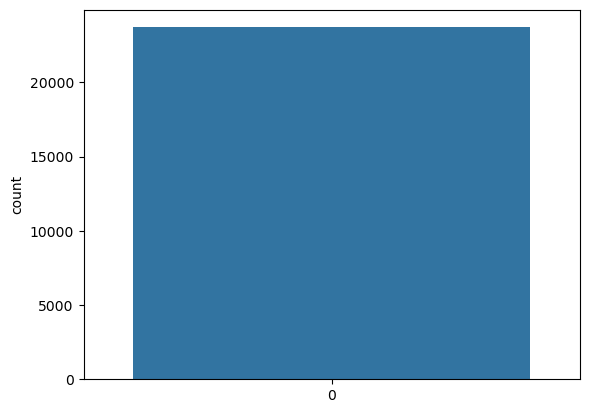

In [9]:
sns.countplot(df['gender'])

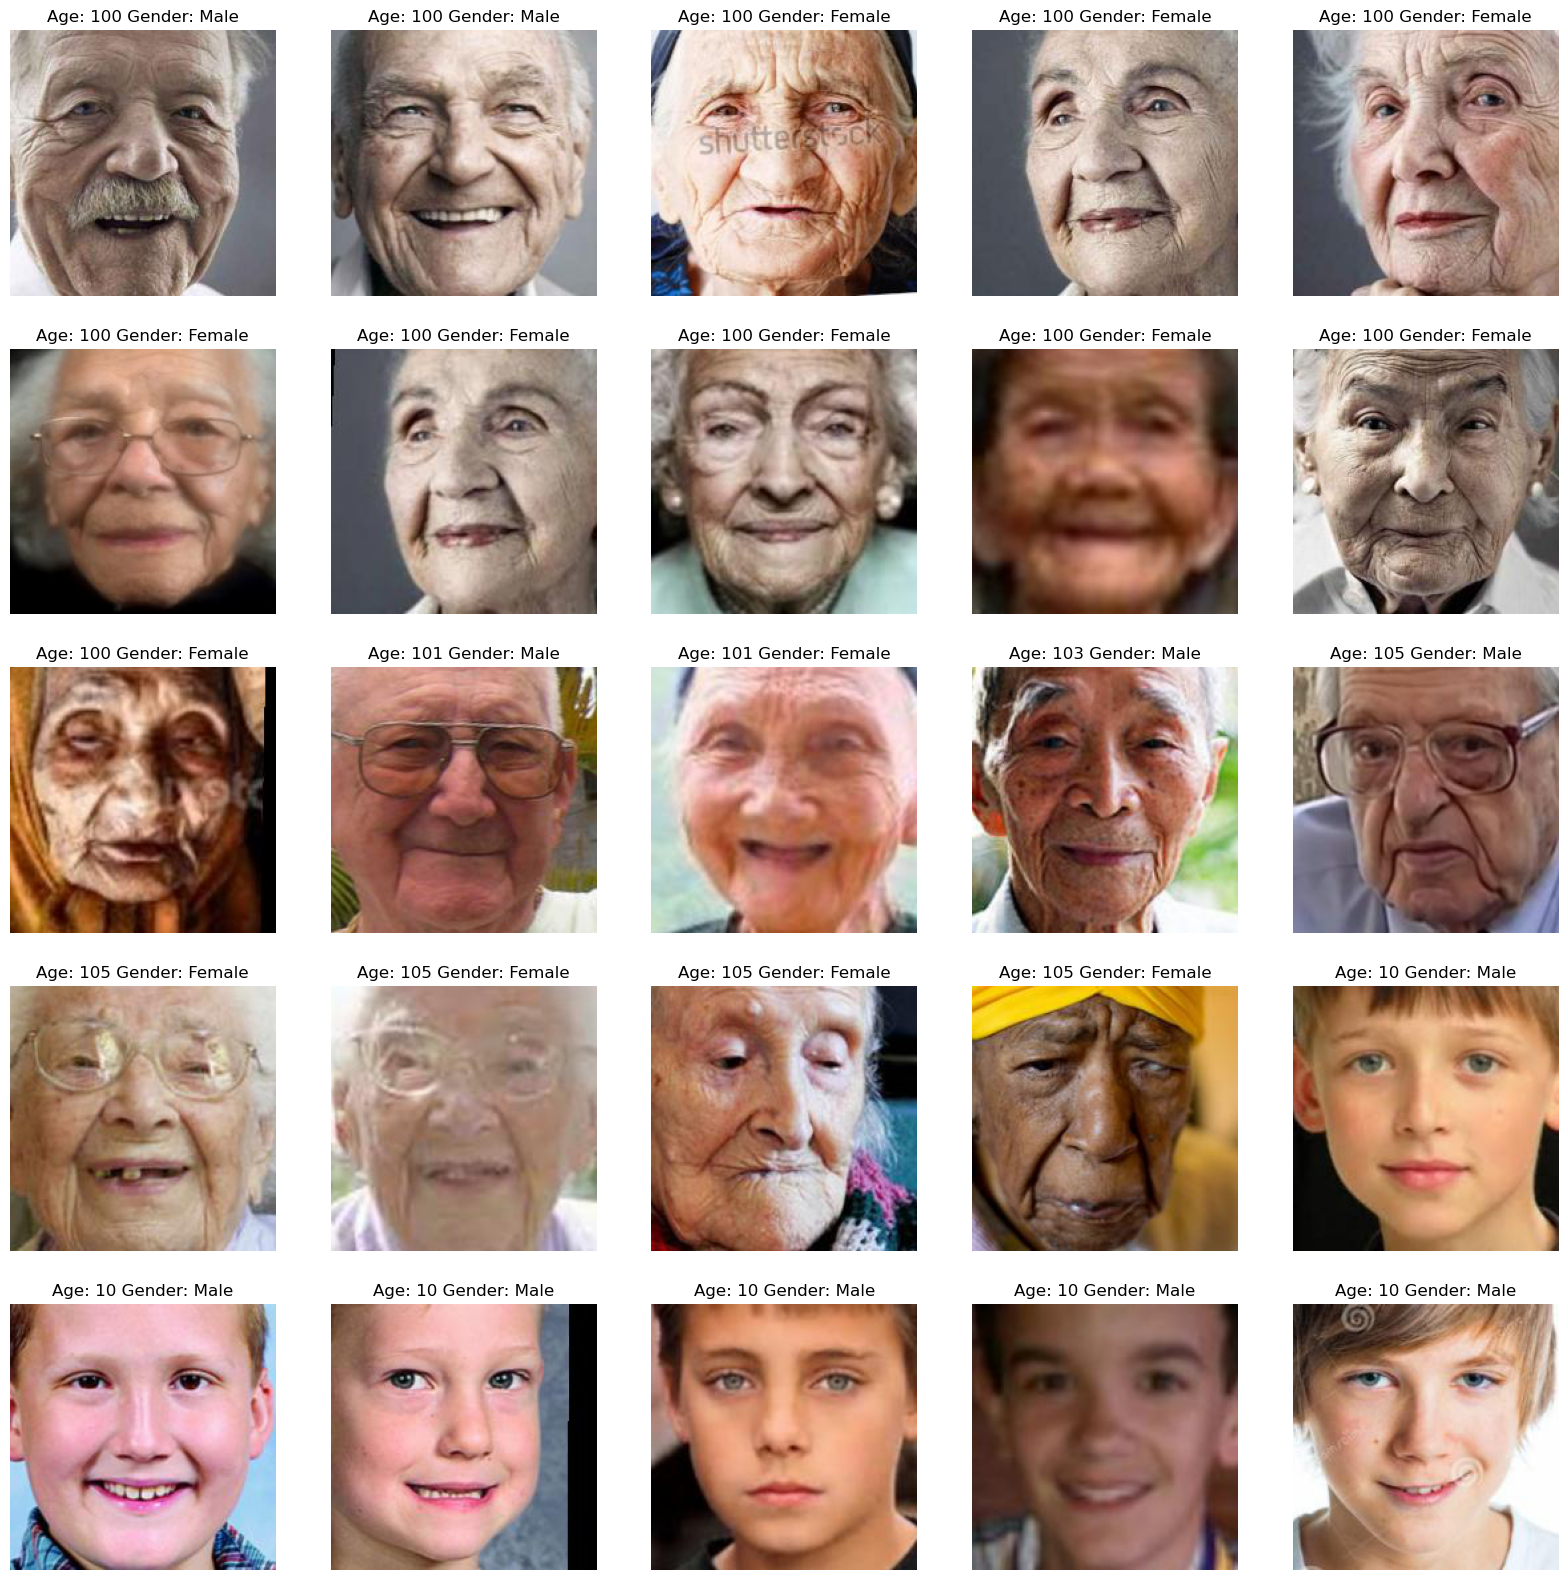

In [10]:
plt.figure(figsize=(20,20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [11]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [12]:
X = extract_features(df['image'])

  0%|          | 0/23705 [00:00<?, ?it/s]

In [13]:
X.shape

(23705, 128, 128, 1)

In [14]:
X = X/255.0

In [15]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [16]:
input_shape = (128, 128, 1)
inputs = Input((input_shape))

In [17]:
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [18]:
import keras
from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler(epoch,lr):
  if epoch <=3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [19]:
lr=0.1
for i in range(20):
  lr= scheduler(i,lr)

In [20]:
callback = LearningRateScheduler(scheduler)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]']   

In [22]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=15, validation_split=0.2)

Epoch 1/15
593/593 [==============================] - 122s 203ms/step - loss: 11.4015 - gender_out_loss: 0.7108 - age_out_loss: 10.6907 - gender_out_accuracy: 0.5088 - age_out_accuracy: 0.0591 - val_loss: 36.2000 - val_gender_out_loss: 0.6897 - val_age_out_loss: 35.5103 - val_gender_out_accuracy: 0.5834 - val_age_out_accuracy: 0.0000e+00
Epoch 2/15
593/593 [==============================] - 121s 203ms/step - loss: 8.8174 - gender_out_loss: 0.5403 - age_out_loss: 8.2771 - gender_out_accuracy: 0.7190 - age_out_accuracy: 0.0462 - val_loss: 30.6876 - val_gender_out_loss: 0.5024 - val_age_out_loss: 30.1852 - val_gender_out_accuracy: 0.7619 - val_age_out_accuracy: 0.0000e+00
Epoch 3/15
593/593 [==============================] - 121s 205ms/step - loss: 7.5873 - gender_out_loss: 0.3944 - age_out_loss: 7.1929 - gender_out_accuracy: 0.8202 - age_out_accuracy: 0.0215 - val_loss: 28.3088 - val_gender_out_loss: 0.4783 - val_age_out_loss: 27.8305 - val_gender_out_accuracy: 0.7724 - val_age_out_accur

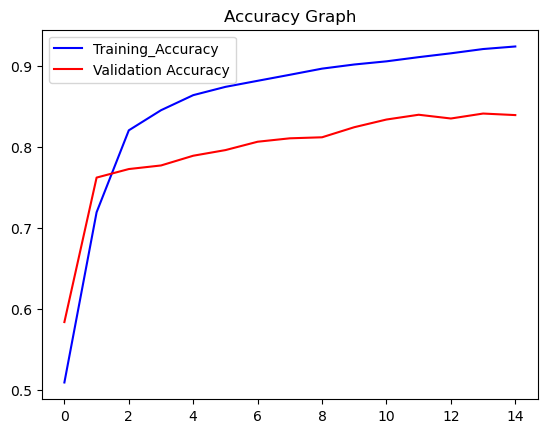

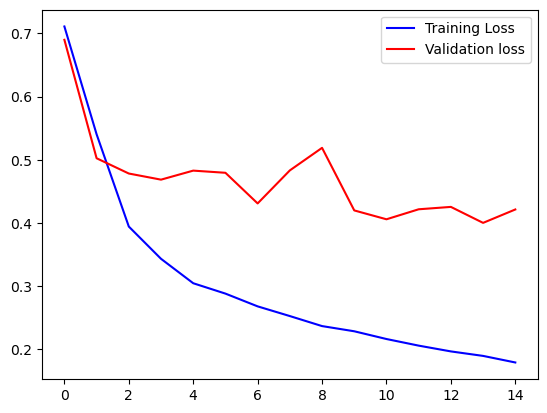

In [23]:
#plot the results

acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training_Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.legend()
plt.show()

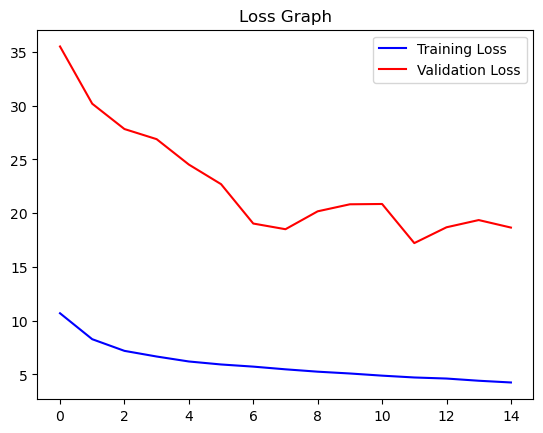

In [24]:
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

image_index = 19345
print("Original Gender:", gender_dict[y_gender[image_index]],"Original Age:", y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 12
1/1 [==============================] - 0s 93ms/step
Predicted Gender: Female Predicted Age: 11


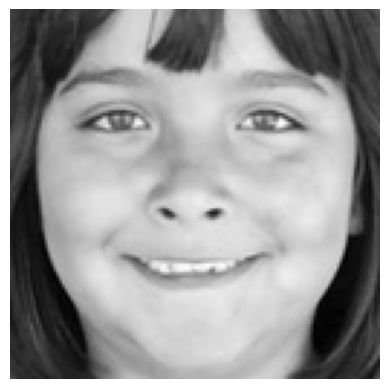

In [25]:
#Prediction with index number

image_index = 300
print("Original Gender:", gender_dict[y_gender[image_index]],"Original Age:", y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

D:/DataScience/Project/UTKface27k/26_0_0_20170120140714337.jpg.chip.jpg
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Male Predicted Age: 25


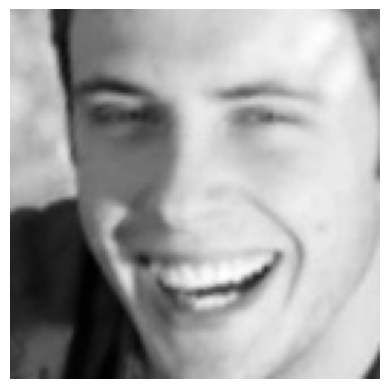

In [27]:
#using tkinter, testing with multiple images

def detect(val):
    image_index = val
    #print("Original Gender:", gender_dict[y_gender[image_index]],"Original Age:", y_age[image_index])
    pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
    pred_gender = gender_dict[round(pred[0][0][0])]
    pred_age = round(pred[1][0][0])
    print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
    plt.axis('off')
    plt.imshow(X[image_index].reshape(128, 128), cmap='gray');


from IPython.display import Image
from tkinter import Tk, filedialog
root = Tk()
root.withdraw()

file_paths = filedialog.askopenfilenames()

for file_path in file_paths:
    filename = os.path.basename(file_path)
    s = 'D:/DataScience/Project/UTKface27k/' + filename
print(s)
tr=0
for j in range(23705):
    if s in (df.iloc[j][0]):
        tr=1
        detect(j)
if tr==0:
    print('''
      SORRY.......|
          This Image is not Trained''')

In [28]:
def test_extract_ftrs(image2):
  img = load_img(image2, grayscale=True)
  img = img.resize((128, 128))
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img/255
  return img

file prithvi2.jpg
1/1 [==============================] - 0s 17ms/step
Predicted Gender: Male Predicted Age: 33


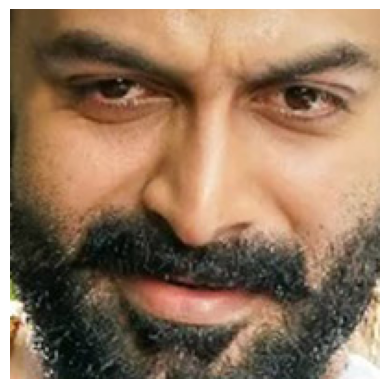

In [54]:
#testing with untrained images

file_paths = filedialog.askopenfilenames()

for file_path in file_paths:
    filename = os.path.basename(file_path)
    print("file", filename)

tst_img = 'D:/DataScience/Project/Testing7/'+filename
features = test_extract_ftrs(tst_img)
pred = model.predict(features)
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(np.array(load_img(tst_img)));